# Climate Change Exploration: Manalua Bay Region, Hawai'i
## Fall 2021
### Elmera Azadpour
All scripts and data can be accessed from: 
https://github.com/aloha-aina/Aloha-Aina-Master

In [3]:
## import libraries:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
import s3fs
import kedro
import nc_time_axis

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [4]:
## browse CMIP6 Public Data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ua,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,va,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [15]:
## filter to find monthly surface air temperature for historical experiments
## pr = preciputaion_flux = kg m-2 s-1
df_pr = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical'")
df_pr

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9463,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
10552,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
13708,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22363,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
22610,CMIP,IPSL,IPSL-CM6A-LR,historical,r11i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
...,...,...,...,...,...,...,...,...,...,...,...
520172,CMIP,MRI,MRI-ESM2-0,historical,r10i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210813
520250,CMIP,MRI,MRI-ESM2-0,historical,r6i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210907
520486,CMIP,KIOST,KIOST-ESM,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/KIOST/KIOST-ESM/historic...,NaN,20210928
520490,CMIP,CMCC,CMCC-CM2-SR5,historical,r3i1p2f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211108


In [17]:
## filtering to find just the models from NCAR
df_pr_noaa = df_pr.query('institution_id == "NOAA-GFDL"')
df_pr_noaa

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9463,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
10552,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
13708,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
245241,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [18]:
## load data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_pr_noaa.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/pr/gr1/v20190726/


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            pr
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-09-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/29468e1c-b66b-40d6-92aa-9851fba964ee...
    version_id:             v20190726

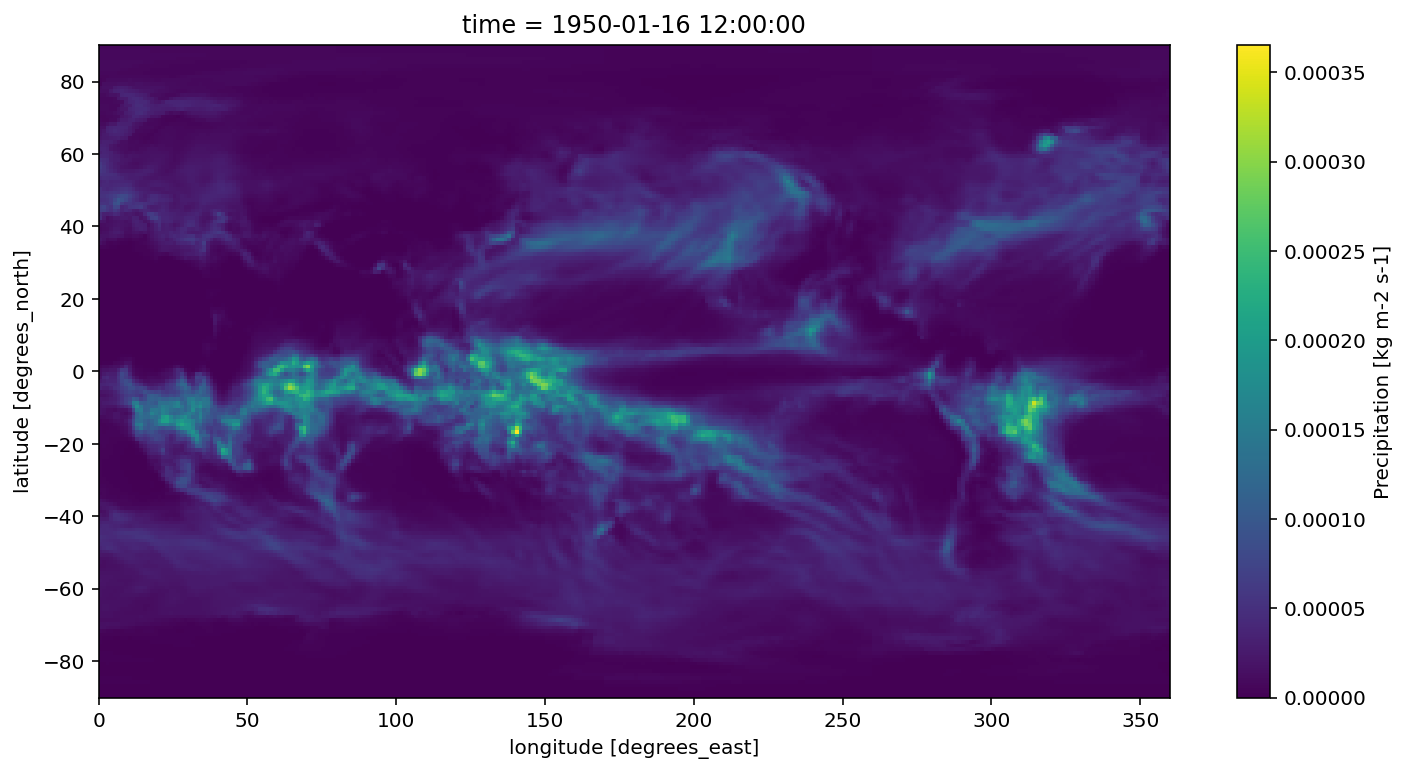

In [19]:
## Plot a map from a specific date.
ds.pr.sel(time='1950-01').squeeze().plot()


In [20]:
## timeseries of precipiation_flux.
## need the area weighting factor for each gridpoint.
df_area = df.query("variable_id == 'areacella' & source_id == 'GFDL-ESM4'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 288, bnds: 2)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    tracking_id:            hdl:21.14100/ecf65f3a-453f-49ee-969a-3b4bc51635de
    variable_id:            areacella
    variant_info:           N/A
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/ecf65f3a-453f-49ee-969a-3b4bc51635de
    version_id:             v20180701

In [21]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
pr_timeseries = (ds.pr * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
pr_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

In [22]:
%time pr_timeseries.load() ## data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

CPU times: user 6.68 s, sys: 3.13 s, total: 9.81 s
Wall time: 20.4 s


<xarray.DataArray (time: 1980)>
array([2.6857771e-05, 2.6683980e-05, 2.6274247e-05, ..., 2.6282849e-05,
       2.6379876e-05, 2.6739164e-05], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

Text(0.5, 1.0, 'Global Mean Precipitation Flux')

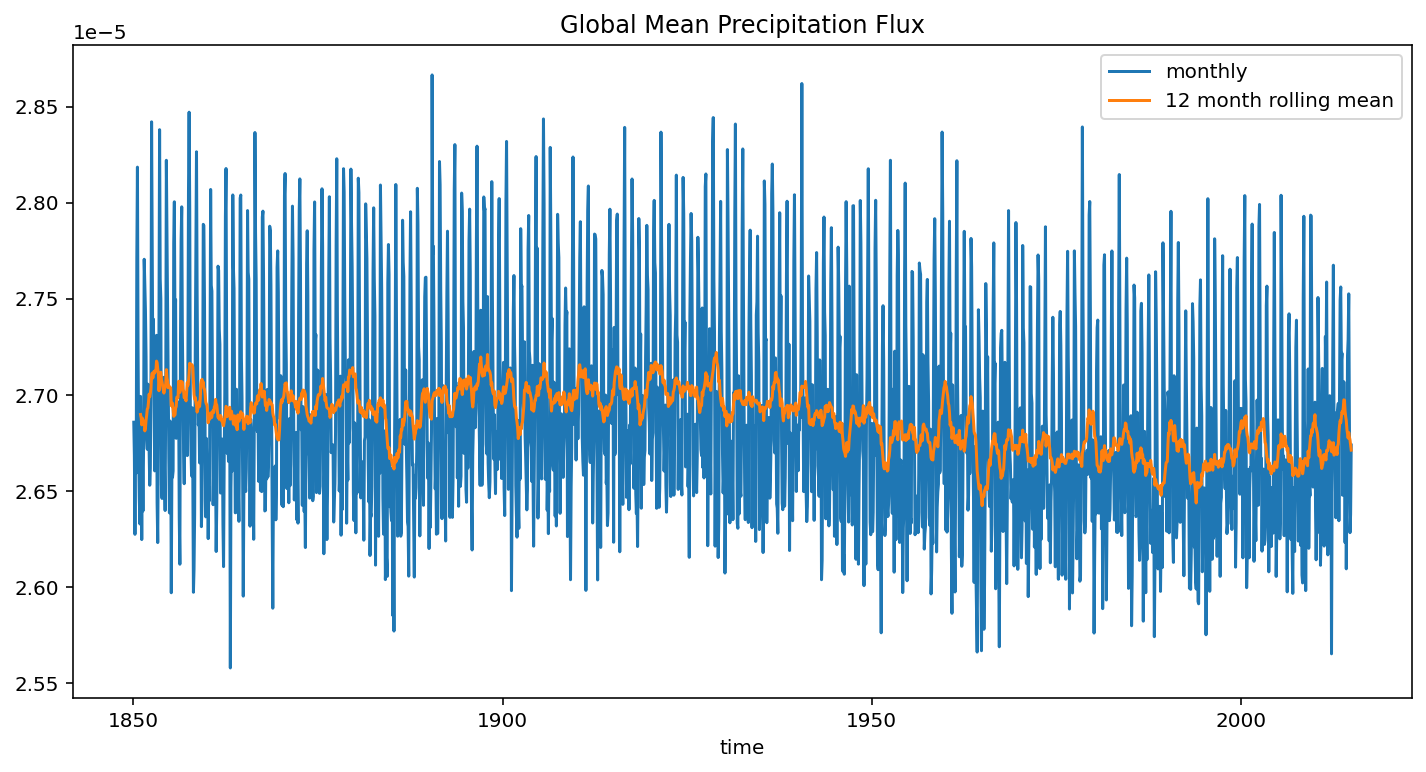

In [23]:
pr_timeseries.plot(label='monthly')
pr_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Precipitation Flux')

### Let's focus in on Hawaii now

In [25]:
# Create logical masks for lat and lon variables
mask_lon = (ds.pr.lon >= 21.2) & (ds.pr.lon <= 21.8)
mask_lat = (ds.pr.lat >= -158.4) & (ds.pr.lat <= -157.6)
mask_lat
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr=ds.pr.where(mask_lon & mask_lat)
oahu_pr

<xarray.DataArray 'pr' (time: 1980, lat: 180, lon: 288)>
dask.array<where, shape=(1980, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

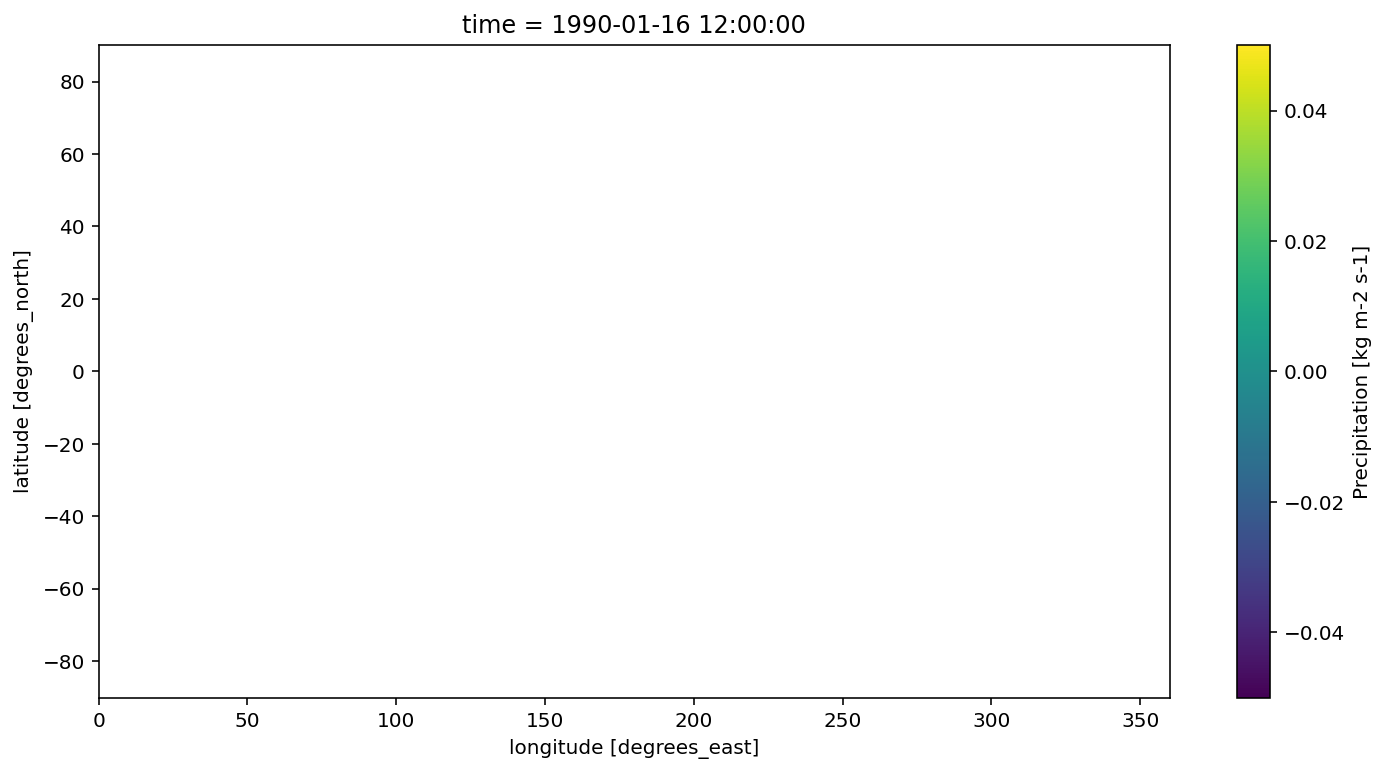

In [31]:
## Plot a map from a specific date and lat and long for Oahu.

oahu_pr.sel(time='1950-01').squeeze().plot()